In [29]:
import pickle
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='poster')

In [30]:
with open('results/01_compare_baseline_models.pickle', 'rb') as f:
    svc_results, log_reg_results, random_forest_results, evaluated_datasets, baseline_times = pickle.load(f)
    
database = pd.read_json("database.json").T
database.loc[:, 'nrow'] = np.minimum(10000, database['nrow'])

with open('results/02_lightgbm_n_iter_10.pickle', 'rb') as f:
    lightgbm_10_results, lgb_10_times = pickle.load(f)
    
with open('results/02_lightgbm_n_iter_25.pickle', 'rb') as f:
    lightgbm_25_results, lgb_25_times = pickle.load(f)
    
with open('results/03_autogluon_sec_60.pickle', 'rb') as f:
    autogluon_60s_results, autogluon_60s_times = pickle.load(f)
    
with open('results/03_autogluon_sec_120.pickle', 'rb') as f:
    autogluon_120s_results, autogluon_60s_times = pickle.load(f)

In [31]:
svc_df = pd.DataFrame(svc_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
svc_df['model'] = 'SVC'
log_reg_df = pd.DataFrame(log_reg_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
log_reg_df['model'] = 'Logistic Regression'
random_forest_df = pd.DataFrame(random_forest_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
random_forest_df['model'] = 'Random Forest'
lightgbm_10_df = pd.DataFrame(lightgbm_10_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
lightgbm_10_df['model'] = 'LightGBM (n_iter=10)'
lightgbm_25_df = pd.DataFrame(lightgbm_25_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
lightgbm_25_df['model'] = 'LightGBM (n_iter=25)'
autogluon_60s_df = pd.DataFrame(autogluon_60s_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
autogluon_60s_df['model'] = 'AutoGluon (sec=60)'
autogluon_120s_df = pd.DataFrame(autogluon_120s_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
autogluon_120s_df['model'] = 'AutoGluon (sec=120)'

In [32]:
results_df = pd.concat([svc_df, log_reg_df, random_forest_df, lightgbm_10_df, lightgbm_25_df, autogluon_60s_df, autogluon_120s_df], axis=0)
results_df.columns = ['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4', 'model']
results_df = results_df.join(database, how='left')
results_df['mean_auroc'] = results_df[['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4']].mean(1)
results_df['min_auroc'] = results_df[['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4']].min(1)
results_df['max_auroc'] = results_df[['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4']].max(1)
results_df['std_auroc'] = results_df[['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4']].std(1)
results_df['dataset'] = results_df.index

In [10]:
# how often each one is best.
# anything within 0.5% of the best counts as a tie and gets full credit
winning_algorithms = []
for dataset in evaluated_datasets:
    df_sub = results_df.loc[dataset]
    highest_auroc = df_sub['mean_auroc'].max()
    winning_algorithms.extend(df_sub.loc[df_sub['mean_auroc'] >= highest_auroc * 0.995, 'model'])

print('Number of datasets each algorithm does best on:')
print(Counter(winning_algorithms), '\n')
print('Average performance for each', results_df.groupby('model')['mean_auroc'].mean(), '\n')
print('Median performance for each', results_df.groupby('model')['mean_auroc'].median())

Number of datasets each algorithm does best on:
Counter({'AutoGluon (sec=120)': 84, 'AutoGluon (sec=60)': 74, 'LightGBM (n_iter=25)': 74, 'LightGBM (n_iter=10)': 68, 'Logistic Regression': 64, 'Random Forest': 64, 'SVC': 35}) 

Average performance for each model
AutoGluon (sec=120)     0.887491
AutoGluon (sec=60)      0.886326
LightGBM (n_iter=10)    0.886359
LightGBM (n_iter=25)    0.888885
Logistic Regression     0.857380
Random Forest           0.886253
SVC                     0.852368
Name: mean_auroc, dtype: float64 

Median performance for each model
AutoGluon (sec=120)     0.924359
AutoGluon (sec=60)      0.925754
LightGBM (n_iter=10)    0.924920
LightGBM (n_iter=25)    0.927121
Logistic Regression     0.891617
Random Forest           0.922966
SVC                     0.880665
Name: mean_auroc, dtype: float64


<AxesSubplot:xlabel='mean_auroc', ylabel='model'>

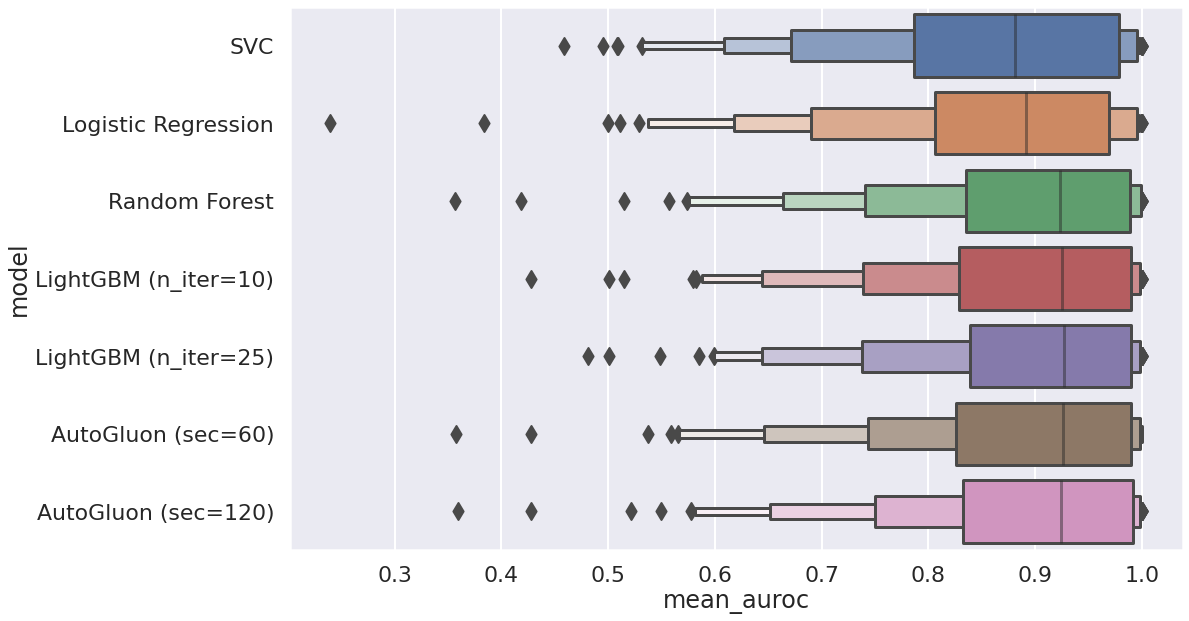

In [35]:
# distributions of each algorithm's mean aurocs
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)
sns.boxenplot(data=results_df, x="mean_auroc", y='model', ax=ax)

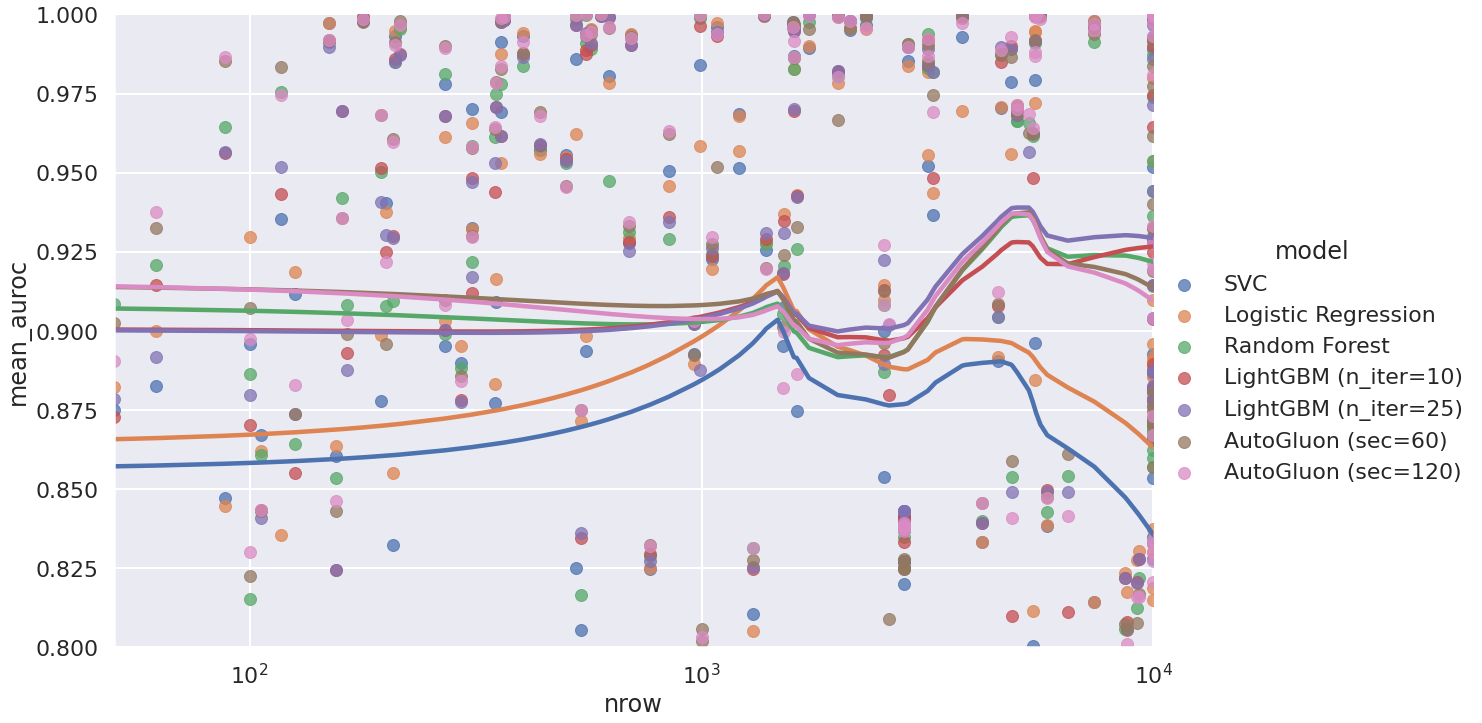

In [9]:
# mean auroc vs number of samples in the data
g = sns.lmplot(
    data=results_df,
    x="nrow", y="mean_auroc",
    hue="model",
    lowess=True,
    height=10,
    aspect=1.6,
    scatter_kws={'alpha': 0.75}
)
g.set(ylim=[0.8, 1.0])
g.set(xscale="log")

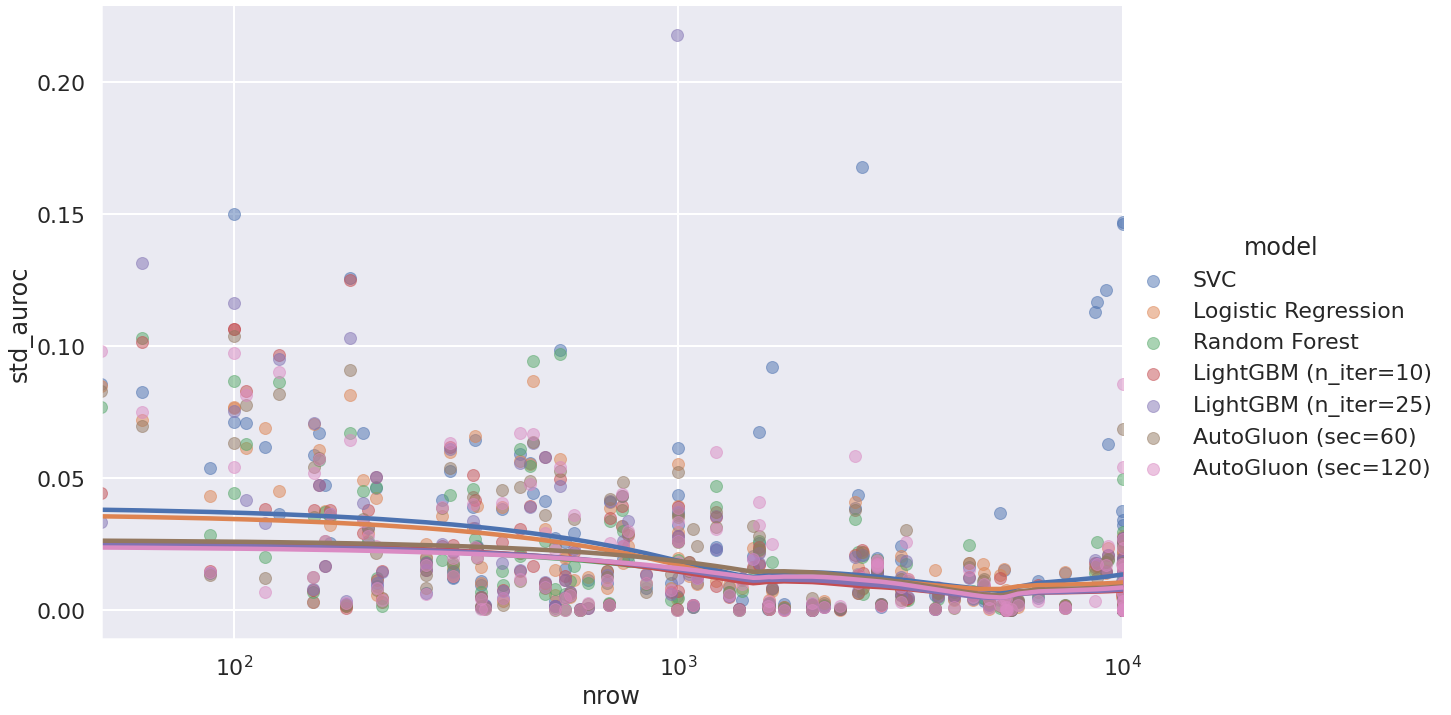

In [10]:
# standard deviation of auroc (across folds) vs number of samples in the data
g = sns.lmplot(
    data=results_df,
    x="nrow", y="std_auroc",
    hue="model",
    lowess=True,
    height=10, 
    aspect=1.6,
    scatter_kws={'alpha': 0.5}
)
g.set(xscale="log")

In [13]:
results_df.groupby('dataset')['mean_auroc'].apply(lambda x: np.sort(x)[-1] - np.sort(x)[-2]).sort_values()

dataset
iris                           0.000000
robot-nav-sensor-readings-2    0.000000
robot-nav-sensor-readings-4    0.000000
hayes-roth                     0.000000
banknote-authentication        0.000000
                                 ...   
thoracic-surgery               0.014894
leukemia-haslinger             0.022436
autoUniv-au7-cpd1-500          0.022964
planning-relax                 0.051938
meta-data                      0.324029
Name: mean_auroc, Length: 142, dtype: float64

In [24]:
results_df.loc['planning-relax']

,auroc_split_1,auroc_split_2,auroc_split_3,auroc_split_4,model,nrow,ncol,mv,ir,class,mean_auroc,min_auroc,max_auroc,std_auroc,dataset
planning-relax,0.648019,0.594406,0.358173,0.531250,SVC,182.0,13.0,0.0,0.714286,2.0,0.532962,0.358173,0.648019,0.125920,planning-relax
planning-relax,0.375291,0.356643,0.305288,0.497596,Logistic Regression,182.0,13.0,0.0,0.714286,2.0,0.383705,0.305288,0.497596,0.081493,planning-relax
planning-relax,0.341492,0.403263,0.268029,0.413462,Random Forest,182.0,13.0,0.0,0.714286,2.0,0.356561,0.268029,0.413462,0.067042,planning-relax
planning-relax,0.393939,0.550117,0.268029,0.500000,LightGBM (n_iter=10),182.0,13.0,0.0,0.714286,2.0,0.428021,0.268029,0.550117,0.124963,planning-relax
planning-relax,0.493007,0.589744,0.341346,0.500000,LightGBM (n_iter=25),182.0,13.0,0.0,0.714286,2.0,0.481024,0.341346,0.589744,0.103011,planning-relax
planning-relax,0.333333,0.496503,0.367788,0.514423,AutoGluon (sec=60),182.0,13.0,0.0,0.714286,2.0,0.428012,0.333333,0.514423,0.090827,planning-relax
planning-relax,0.365967,0.463869,0.382212,0.500000,AutoGluon (sec=120),182.0,13.0,0.0,0.714286,2.0,0.428012,0.365967,0.500000,0.064331,planning-relax
